<a href="https://colab.research.google.com/github/pithun/Soil-Classification-Using-ML/blob/master/ML_Code%20-%20DEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/Soil Classification Project/Working_Data'

/content/drive/MyDrive/Soil Classification Project/Working_Data


In [3]:
# Preprocessing on dataset
import cv2 as cv
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from itertools import product
import datetime as dt

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Machine Learning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

#Deep Learning
import tensorflow as tf
import tensorflow_hub as hub
import keras

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
# Parameter tuning


## Generating Images used in the Paper

In [ ]:
test_image = cv.imread('Data/Nsukka-Gravel/Bigger-Size/Close-Range-25-30cm/20240204_101240.jpg')
#test_image = cv.imread('Data/Nsukka-Gravel/Smaller-Size/Close-Range-20-30cm/20240204_102340.jpg')
#test_image = cv.imread('Data/Red-Sand/Close-Range-20cm-30cm/IMG_6932.jpeg')
#test_image = cv.imread('Data/White-Sand/Close-Range-25-30cm/20240201_071815.jpg')

In [ ]:
# Converting to RGB
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)

# Converting to grayscale
test_image_gray = cv.cvtColor(test_image, cv.COLOR_RGB2GRAY)

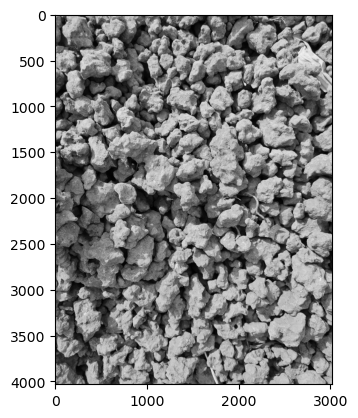

In [ ]:
plt.imshow(test_image_gray, cmap='gray')

In [ ]:
# Step 1. GrayImage
#cv.imwrite('Plans and Paper/Paper Images/Methodology/GrayScale.jpg', test_image_gray)

In [ ]:
# Step 2. Resizing Image
gray_resized = cv.resize(test_image_gray, (500,500))

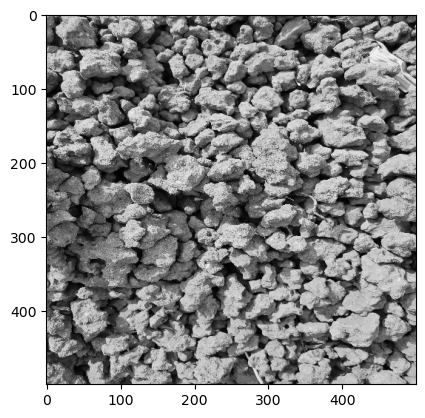

In [ ]:
plt.imshow(gray_resized, cmap='gray')

In [ ]:
#cv.imwrite('Plans and Paper/Paper Images/Methodology/Resize.jpg', gray_resized)

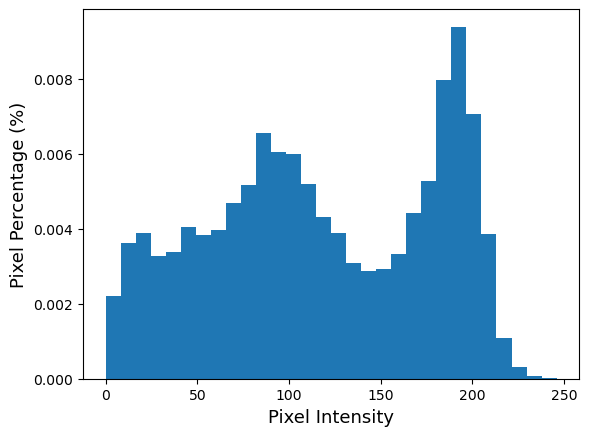

In [ ]:
# Step 3 - Histogram Equalization
plt.hist(gray_resized.flatten(), bins=30, density=True)
plt.xlabel('Pixel Intensity', fontsize=13)
plt.ylabel('Pixel Percentage (%)', fontsize=13)
#plt.savefig('Pixel_distr_before_equal.jpg', dpi=800)

In [ ]:
hist_equ = cv.equalizeHist(gray_resized)

Text(0, 0.5, 'Pixel Percentage (%)')

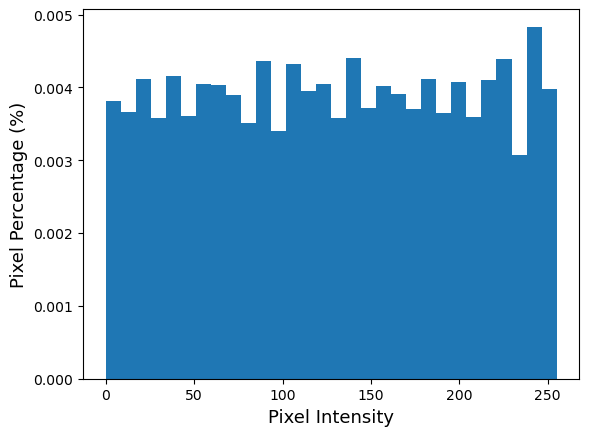

In [ ]:
# Viewing the distribution again
plt.hist(hist_equ.flatten(), bins=30, density=True)
plt.xlabel('Pixel Intensity', fontsize=13)
plt.ylabel('Pixel Percentage (%)', fontsize=13)
#plt.savefig('Pixel_distr_after_equal.jpg', dpi=800)

Compared to the previous plot, the pixel values here are more distributed.

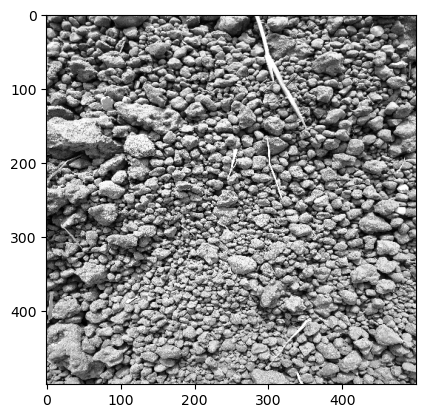

In [ ]:
# Visualizing histogram equalized image
plt.imshow(hist_equ, cmap='gray')

In [ ]:
#cv.imwrite('Plans and Paper/Paper Images/Methodology/histogram_equalized.jpg', hist_equ)

In [ ]:
# Step 4. Blending
blended = 0.7*gray_resized + 0.3*hist_equ
blended = np.uint8(blended)
# Changing to Uint8


In [ ]:
blended.max()

248

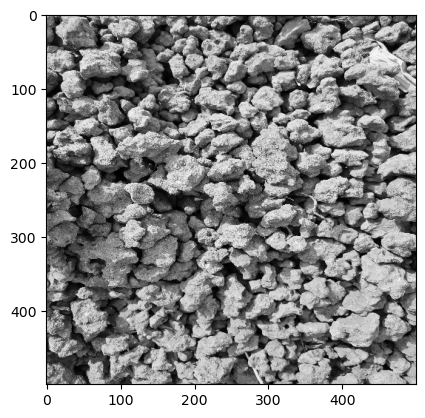

In [ ]:
# Visualizing blended image
plt.imshow(blended, cmap='gray')

In [ ]:
#cv.imwrite('Plans and Paper/Paper Images/Methodology/blended.jpg', blended)

In [ ]:
# Appling Canny Edge Detection
canny_edge_img = cv.Canny(blended, 100, 350)

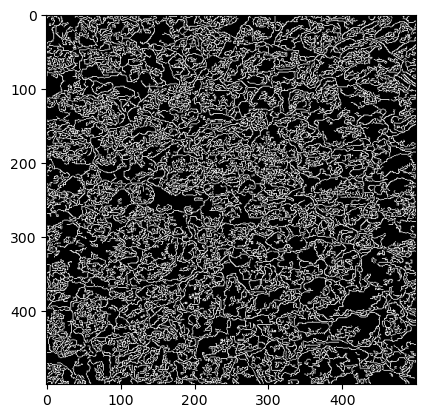

In [ ]:
# Visualizing blended image
plt.imshow(canny_edge_img, cmap='gray')

In [ ]:
def add_patch(x,y, dist_x, dist_y):
    plt.gca().add_patch(Rectangle((x,y),dist_x,dist_y,
                    edgecolor='red',
                    facecolor='none',
                    lw=3))

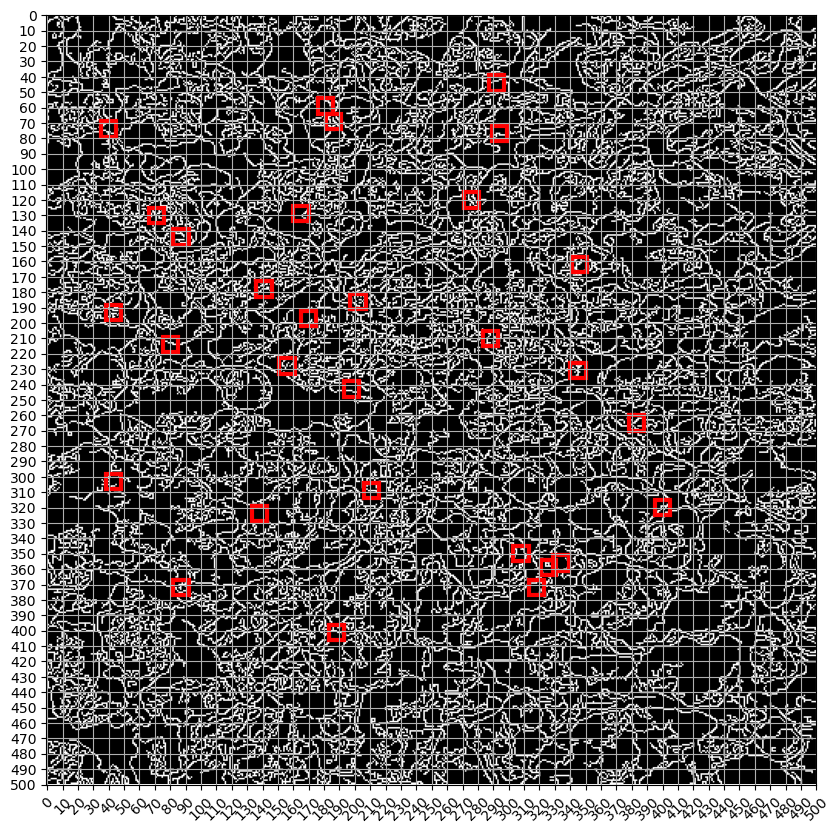

In [ ]:
# Generating random positions
np.random.seed(30)
x=np.random.randint(20, 400, 30)
y=np.random.randint(20, 400, 30)

# Visualizing canny edge image
plt.figure(figsize=(12,10))
plt.imshow(canny_edge_img, cmap='gray')
for corr_x, corr_y in zip(x,y):
    add_patch(corr_x, corr_y, 10, 10)
plt.xticks(range(0,501,10), rotation=45)
plt.yticks(range(0,501,10))
plt.grid()
#plt.savefig('Naive_particle_size.jpg', dpi=800)

In [ ]:
#cv.imwrite('Plans and Paper/Paper Images/Methodology/canny_edge.jpg', canny_edge_img)

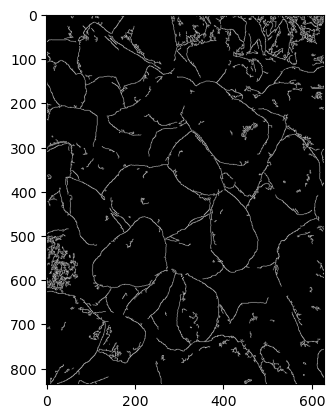

In [ ]:
plt.imshow(canny_edge_img, cmap='gray')

In [ ]:
# Understanding Canny edge detection

# Training the model with ADABoost
1. Extract the percentiles into a table
2.

One thing I've observed from numpy arrays is the dimensions are the latest i.e (3x10x2) means we have 3 dimensions of (10) rows by 2 columns

In [ ]:
def generate_perc_dist_columns(perc_distance=5):
    col_names=[]
    for dist in range(0,101,perc_distance):
        col_names.append('perc_'+str(dist))
    col_names.append('distance')
    return col_names

In [ ]:
# Making the dataframe
names=generate_perc_dist_columns(perc_distance=1)
names.append('class')
#names_test=generate_perc_dist_columns()
#names_train.append('class')

working_df_train = pd.DataFrame(columns=names)
working_df_test = pd.DataFrame(columns=names)

In [ ]:
working_df_test

,perc_0,perc_1,perc_2,perc_3,perc_4,perc_5,perc_6,perc_7,perc_8,perc_9,...,perc_93,perc_94,perc_95,perc_96,perc_97,perc_98,perc_99,perc_100,distance,class


In [ ]:
def preprocess(image_path, canny_x=100, canny_y=350, blend_x=0.7, blend_y=0.3):
    image = cv.imread(image_path)
    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Converting to grayscale
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    # Resizing image
    gray_resized = cv.resize(image_gray, (500,500))

    # histogram equalization
    hist_equ = cv.equalizeHist(gray_resized)

    blended = blend_x*gray_resized + blend_y*hist_equ
    blended = np.uint8(blended)
    #plt.imshow(blended, cmap='gray')
    #plt.show()

    # Appling Canny Edge Detection
    canny_edge_img = cv.Canny(blended, canny_x, canny_y)
    canny_edge_img_unit = canny_edge_img/255

    return canny_edge_img_unit

In [ ]:
def get_pixel_sum(full_image, no_of_patches=25):
    size_x=full_image.shape[0]
    size_y=full_image.shape[1]
    down_size=int((size_x*size_y/no_of_patches)**(1/4))
    patches = full_image.reshape(no_of_patches, down_size, down_size, down_size, down_size)
    values=[]

    for img_patch_no in range(no_of_patches):
        image_patch = patches[img_patch_no]
        first_sum = np.sum(image_patch, axis=(1))
        second_sum = np.sum(first_sum, axis=(2))
        values.append(second_sum.flatten())

    final = np.array(values).ravel()
    return final

In [ ]:
# Correct get pixel sum function
def get_pixel_sum_v2(full_image, patch_size=10):
    values = []
    current_row = 0
    nxt_row = patch_size
    current_column = 0
    nxt_column = patch_size
    size_x=full_image.shape[0]
    size_y=full_image.shape[1]
    each_loop=int(size_x/patch_size)

    #print(int((size_x*size_y)/(patch_size**2)))
    #for a in range(int((size_x*size_y)/(patch_size**2))):
    for a in range(each_loop):
        for b in range(each_loop):
            patch=full_image[current_row:nxt_row, current_column:nxt_column]
            #print(sum(patch), '=', np.sum(patch))
            #print(current_column, nxt_column)
            val = np.sum(patch)
            values.append(val)
            current_column+=patch_size
            nxt_column+=patch_size
        current_row+=patch_size
        nxt_row+=patch_size
        current_column=0
        nxt_column=patch_size
        #print(values)
    return values

In [ ]:
def get_percentiles_distance(naive_particle_sizes, perc_distance=5, image_distance='short'):
    percentiles = []
    for a in range(0,101,perc_distance):
        percentiles.append(np.percentile(naive_particle_sizes, a))

    # Define range and standard deviation
    range_min = 20  # Minimum value in the range
    range_max = 30  # Maximum value in the range
    std_dev = 2  # Standard deviation

    # Generate a random number with specified range and standard deviation
    random_number = np.random.normal(loc=(range_max + range_min) / 2, scale=std_dev)

    # Ensure the generated number falls within the specified range
    random_number = np.clip(random_number, range_min, range_max)
    percentiles.append(random_number)

    return percentiles

    #df.loc[len(df)] = percentiles
    #df = df.append(pd.Series(new_record, index=df.columns), ignore_index=True)

In [4]:
def get_metrics(y_true, y_pred):
    '''Gets the accuracy, micro, macro and weighted recall, precision and f1'''
    micro_prec=precision_score(y_true, y_pred, average='micro')
    macro_prec=precision_score(y_true, y_pred, average='macro')
    weighted_prec=precision_score(y_true, y_pred, average='weighted')
    micro_recall=recall_score(y_true, y_pred, average='micro')
    macro_recall=recall_score(y_true, y_pred, average='macro')
    weighted_recall=recall_score(y_true, y_pred, average='weighted')
    micro_f1=f1_score(y_true, y_pred, average='micro')
    macro_f1=f1_score(y_true, y_pred, average='macro')
    weighted_f1=f1_score(y_true, y_pred, average='weighted')
    accuracy=accuracy_score(y_true, y_pred)
    return micro_prec, macro_prec, weighted_prec, micro_recall, macro_recall, weighted_recall, micro_f1, macro_f1, weighted_f1, accuracy


## Used this to test the correctness of the get pixel sum function
It was wrong so I had to develop a v2 function

In [ ]:
im = preprocess('Data/Nsukka-Gravel/Bigger-Size/Close-Range-25-30cm/20240204_101240.jpg')

In [ ]:
get_pixel_sum(im)

array([18., 25., 21., ..., 13., 17., 12.])

In [ ]:
%%time
# The smaller the kernel size the more the time
len(get_pixel_sum_v2(im, 10))

CPU times: total: 31.2 ms
Wall time: 28 ms


2500

In [ ]:
# Manually slicing to confirm the summation
sum(sum(im[0:5, 0:5]))

5.0

## Generating the Data

In [5]:
# Importing images
soil_0_path='Nsukka-Gravel/Smaller-Size/Close-Range-20-30cm/'
soil_1_path='Nsukka-Gravel/Bigger-Size/Close-Range-25-30cm/'
soil_2_path='Red-Sand/Close-Range-20cm-30cm/'
soil_3_path='White-Sand/Close-Range-25-30cm/'

soil_0=sorted(os.listdir(soil_0_path))[:100]
soil_1=sorted(os.listdir(soil_1_path))[:100]
soil_2=sorted(os.listdir(soil_2_path))[:100]
soil_3=sorted(os.listdir(soil_3_path))[:100]

In [6]:
all_soils=[soil_0, soil_1, soil_2, soil_3]
all_soil_path=[soil_0_path, soil_1_path, soil_2_path, soil_3_path]

In [ ]:
##[(2, (0, 1), (50, 200))

In [ ]:
%%time
# We're using 25% of all soils for testing and 75% for training
# Next step is to populate the data frame
np.random.seed(42)

for soil, soil_path, class_ in zip(all_soils, all_soil_path, [0,1,2,2]):
    train=soil[0:int(len(soil)*0.75)]
    test=soil[int(len(soil)*0.75):]
    print(f"For current soil in class {class_}, we have {len(train)} training data and {len(test)} testing data!")

    print ('Working on Training Set')
    for soil_pic in train:
        naive_particle_pic=preprocess(soil_path+soil_pic, blend_x=0, blend_y=1, canny_x=50, canny_y=200)
        #print(naive_particle_pic, soil_path+soil_pic)
        naive_particle_sum=get_pixel_sum_v2(naive_particle_pic, 2)
        #print(type(naive_particle_sum))
        percentiles=get_percentiles_distance(naive_particle_sum, perc_distance=1)
        #print(percentiles)
        percentiles.append(class_)
        working_df_train.loc[len(working_df_train)] = percentiles

    print('\n','======Finished Training set=======', '\n')
    print ('Working on Testing Set')
    for soil_pic_test in test:
        naive_particle_pic_test=preprocess(soil_path+soil_pic_test, blend_x=0, blend_y=1, canny_x=50, canny_y=200)
        naive_particle_sum_test=get_pixel_sum_v2(naive_particle_pic_test,2)
        percentiles_test=get_percentiles_distance(naive_particle_sum_test, perc_distance=1)
        percentiles_test.append(class_)
        working_df_test.loc[len(working_df_test)] = percentiles_test
    print('\n')


For current soil in class 0, we have 147 training data and 49 testing data!
Working on Training Set

 ======Finished Training set======= 

Working on Testing Set


For current soil in class 1, we have 196 training data and 66 testing data!
Working on Training Set

 ======Finished Training set======= 

Working on Testing Set


For current soil in class 2, we have 106 training data and 36 testing data!
Working on Training Set

 ======Finished Training set======= 

Working on Testing Set


For current soil in class 2, we have 501 training data and 168 testing data!
Working on Training Set

 ======Finished Training set======= 

Working on Testing Set


CPU times: total: 27min 54s
Wall time: 27min 2s


In [ ]:
## 17 mins for one iteration
'''CPU times: total: 17min 20s
Wall time: 17min 54s'''

'CPU times: total: 17min 20s\nWall time: 17min 54s'

In [ ]:
working_df_train

,perc_0,perc_1,perc_2,perc_3,perc_4,perc_5,perc_6,perc_7,perc_8,perc_9,...,perc_93,perc_94,perc_95,perc_96,perc_97,perc_98,perc_99,perc_100,distance,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,25.993428,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,24.723471,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,26.295377,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,28.046060,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,24.531693,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,25.157270,2.0
946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,21.003599,2.0
947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,26.832655,2.0
948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,25.692977,2.0


In [ ]:
X=working_df_train.drop('class', axis=1)
y=working_df_train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
dec_tree = DecisionTreeClassifier(random_state=88)

In [ ]:
dec_tree.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
pred=dec_tree.predict(X_test)

In [ ]:
dec_tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00480986,
       0.61737203, 0.00186071, 0.0200221 , 0.01179268, 0.01256743,
       0.00691418, 0.04593698, 0.00147575, 0.00150308, 0.00200411,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00386507,
       0.00347491, 0.02418133, 0.00995884, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101],
 [Text(0, 0, 'perc_0'),
  Text(1, 0, 'perc_1'),
  Text(2, 0, 'perc_2'),
  Text(3, 0, 'perc_3'),
  Text(4, 0, 'perc_4'),
  Text(5, 0, 'perc_5'),
  Text(6, 0, 'perc_6'),
  Text(7, 0, 'perc_7'),
  Text(8, 0, 'perc_8'),
  Text(9, 0, 'perc_9'),
  Text(10, 0, 'perc_10'),
  Text(11, 0, 'perc_11'),
  Text(12, 0, 'perc_12'),
  Text(13, 0, 'perc_13'),
  Text(14, 0, 'perc_14'),
  Text(15, 0, 'perc_15'),

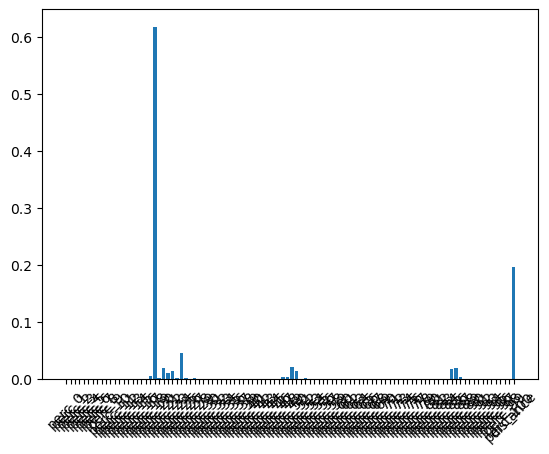

In [ ]:
plt.bar(X.columns,dec_tree.feature_importances_)
plt.xticks(rotation=45)

In [ ]:
precision_score(y_test, pred, average='macro')

0.7133741768775527

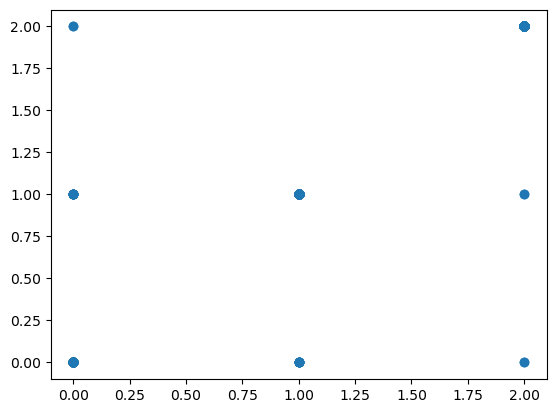

In [ ]:
plt.scatter(y_test, pred)

## Parameter Tuning starts here

In [ ]:
# MASTER PARAM LIST
'''%%time
# Parameters to test
perc_distances=list(range(1,11))

# These kernel shapes have to be multiples of 50
kernel_shapes = [2,5,10,20,25,50]
blending_ratios = [(0, 1), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6,0.4), (0.7,0.3), (0.8,0.2), (0.9,0.1),
            (1, 0)]
canny_x=list(range(50, 201, 50))
canny_y=list(range(200,501,50))

combine_canny=[]
for a in canny_x:
    for b in canny_y:
        combine_canny.append((a,b))

all_parameters= list(product(kernel_shapes, blending_ratios, combine_canny))'''

In [ ]:
%%time
# Parameters to test
perc_distances=[1]

# These kernel shapes have to be multiples of 50
kernel_shapes = [2]
blending_ratios = [(0, 1), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6,0.4), (0.7,0.3), (0.8,0.2), (0.9,0.1),
            (1, 0)]
canny_x=list(range(50, 201, 50))
canny_y=list(range(200,501,50))

combine_canny=[]
for a in canny_x:
    for b in canny_y:
        combine_canny.append((a,b))

all_parameters= list(product(kernel_shapes, blending_ratios, combine_canny))

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
len(all_parameters)

308

In [ ]:
new= ["params","perc_distance", "precision_micro_train", "precision_macro_train", "precision_weighted_train",
        "recall_micro_train", "recall_macro_train", "recall_weighted_train", "f1_micro_train", "f1_macro_train",
        "f1_weighted_train", "accuracy_train", "precision_micro_test", "precision_macro_test", "precision_weighted_test",
        "recall_micro_test", "recall_macro_test", "recall_weighted_test", "f1_micro_test", "f1_macro_test",
        "f1_weighted_test", "accuracy_test"]

In [ ]:
%%time
np.random.seed(42)

metrics_df_columns=new
metrics_df=pd.DataFrame(columns=metrics_df_columns)

# Looping through all
for perc_distance in perc_distances:
    # Making the dataframe
    names=generate_perc_dist_columns(perc_distance=perc_distance)
    names.append('class')
    #names_test=generate_perc_dist_columns()
    #names_train.append('class')

    # We're using 25% of all soils for testing and 75% for training
    # Next step is to populate the data frame

    for params in all_parameters[17:]:
        start_time = dt.datetime.now()
        start_time_conv = start_time.strftime("%Y-%m-%d %H:%M:%S")

        expected_end_time = start_time+dt.timedelta(minutes=17)
        expected_end_time_conv = expected_end_time.strftime("%Y-%m-%d %H:%M:%S")
        print('=====Started process for', params, 'set on', perc_distance, '=====')
        print('Iteration started at:', start_time_conv, 'expected end time is:', expected_end_time_conv)
        working_df_train = pd.DataFrame(columns=names)
        working_df_test = pd.DataFrame(columns=names)

        for soil, soil_path, class_ in zip(all_soils, all_soil_path, [0,1,2,2]):
            train=soil[0:int(len(soil)*0.75)]
            test=soil[int(len(soil)*0.75):]
            print(f"For current soil in class {class_}, we have {len(train)} training data and {len(test)} testing data!")

            print ('Working on Training Set')
            for soil_pic in tqdm(train):
                #print(params[0],'canny_x', params[2][0], 'canny_y', params[2][1], 'blend_x',params[1][0], 'blend_y',params[1][1])
                naive_particle_pic=preprocess(soil_path+soil_pic, canny_x=params[2][0],canny_y=params[2][1],
                                              blend_x=params[1][0], blend_y=params[1][1])
                #print(naive_particle_pic, soil_path+soil_pic)
                naive_particle_sum=get_pixel_sum_v2(naive_particle_pic, params[0])
                #print(type(naive_particle_sum))
                percentiles=get_percentiles_distance(naive_particle_sum, perc_distance=perc_distance)
                #print(percentiles)
                percentiles.append(class_)
                working_df_train.loc[len(working_df_train)] = percentiles

            print('\n','======Finished Training set=======', '\n')
            print ('Working on Testing Set')
            for soil_pic_test in tqdm(test):
                naive_particle_pic_test=preprocess(soil_path+soil_pic_test, canny_x=params[2][0],canny_y=params[2][1],
                                              blend_x=params[1][0], blend_y=params[1][1])
                naive_particle_sum_test=get_pixel_sum_v2(naive_particle_pic_test, params[0])
                percentiles_test=get_percentiles_distance(naive_particle_sum_test, perc_distance=perc_distance)
                percentiles_test.append(class_)
                working_df_test.loc[len(working_df_test)] = percentiles_test
            print('\n')
        dec_tree = DecisionTreeClassifier(random_state=88)
        dec_tree.fit(working_df_train.drop('class', axis=1), working_df_train[['class']])
        y_pred_tr=dec_tree.predict(working_df_train.drop('class', axis=1))
        y_pred_te=dec_tree.predict(working_df_test.drop('class', axis=1))

        precision_micro_train, precision_macro_train,precision_weighted_train,recall_micro_train,recall_macro_train, recall_weighted_train,f1_micro_train,f1_macro_train,f1_weighted_train, accuracy_train=get_metrics(working_df_train[['class']],y_pred_tr)
        precision_micro_test, precision_macro_test,precision_weighted_test,recall_micro_test,recall_macro_test,recall_weighted_test,f1_micro_test,f1_macro_test,f1_weighted_test, accuracy_test=get_metrics(working_df_test[['class']],y_pred_te)
        metrics_df.loc[len(metrics_df)] = [params, perc_distance, precision_micro_train, precision_macro_train,precision_weighted_train,recall_micro_train,recall_macro_train,recall_weighted_train,f1_micro_train,f1_macro_train,f1_weighted_train, accuracy_train, precision_micro_test,precision_macro_test,precision_weighted_test,recall_micro_test,recall_macro_test,recall_weighted_test,f1_micro_test,f1_macro_test,f1_weighted_test, accuracy_test]
        if metrics_df.shape[0] in list(range(10, 20001, 10)):
            metrics_df.to_csv('metrics'+str(metrics_df.shape[0])+'.csv')

=====Started process for (2, (0, 1), (150, 350)) set on 1 =====
Iteration started at: 2024-04-11 02:10:32 expected end time is: 2024-04-11 02:27:32
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:59<00:00,  1.60s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.44s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:51<00:00,  1.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.42s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:46<00:00,  1.42s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.36s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:42<00:00,  1.37s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.39s/it]




=====Started process for (2, (0, 1), (150, 400)) set on 1 =====
Iteration started at: 2024-04-11 02:20:12 expected end time is: 2024-04-11 02:37:12
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:46<00:00,  1.42s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.46s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:48<00:00,  1.44s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:42<00:00,  1.36s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:44<00:00,  1.39s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.40s/it]




=====Started process for (2, (0, 1), (150, 450)) set on 1 =====
Iteration started at: 2024-04-11 02:29:36 expected end time is: 2024-04-11 02:46:36
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:48<00:00,  1.45s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.41s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:51<00:00,  1.48s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.45s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:40<00:00,  1.34s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.37s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:47<00:00,  1.43s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.41s/it]




=====Started process for (2, (0, 1), (150, 500)) set on 1 =====
Iteration started at: 2024-04-11 02:39:05 expected end time is: 2024-04-11 02:56:05
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:48<00:00,  1.45s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.42s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:51<00:00,  1.48s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.44s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:44<00:00,  1.39s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.39s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:44<00:00,  1.39s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.46s/it]




=====Started process for (2, (0, 1), (200, 200)) set on 1 =====
Iteration started at: 2024-04-11 02:48:36 expected end time is: 2024-04-11 03:05:36
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:49<00:00,  1.46s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.45s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:50<00:00,  1.47s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.46s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:43<00:00,  1.38s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.40s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:52<00:00,  1.51s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.43s/it]




=====Started process for (2, (0, 1), (200, 250)) set on 1 =====
Iteration started at: 2024-04-11 02:58:16 expected end time is: 2024-04-11 03:15:16
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:51<00:00,  1.48s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.46s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:51<00:00,  1.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.46s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:56<00:00,  1.56s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.39s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:48<00:00,  1.44s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.44s/it]




=====Started process for (2, (0, 1), (200, 300)) set on 1 =====
Iteration started at: 2024-04-11 03:08:08 expected end time is: 2024-04-11 03:25:08
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:53<00:00,  1.51s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.43s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:51<00:00,  1.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.50s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:46<00:00,  1.43s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.40s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:49<00:00,  1.46s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.45s/it]




=====Started process for (2, (0, 1), (200, 350)) set on 1 =====
Iteration started at: 2024-04-11 03:17:54 expected end time is: 2024-04-11 03:34:54
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:51<00:00,  1.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:52<00:00,  1.50s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.51s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:44<00:00,  1.40s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.42s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:46<00:00,  1.43s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]




=====Started process for (2, (0, 1), (200, 400)) set on 1 =====
Iteration started at: 2024-04-11 03:27:37 expected end time is: 2024-04-11 03:44:37
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:52<00:00,  1.50s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:51<00:00,  1.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.51s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:40<00:00,  1.34s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.30s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:35<00:00,  1.28s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.27s/it]




=====Started process for (2, (0, 1), (200, 450)) set on 1 =====
Iteration started at: 2024-04-11 03:36:56 expected end time is: 2024-04-11 03:53:56
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:36<00:00,  1.28s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.26s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:39<00:00,  1.33s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.30s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:31<00:00,  1.22s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:30<00:00,  1.22s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:34<00:00,  1.25s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.27s/it]




=====Started process for (2, (0, 1), (200, 500)) set on 1 =====
Iteration started at: 2024-04-11 03:45:23 expected end time is: 2024-04-11 04:02:23
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:37<00:00,  1.30s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.27s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:38<00:00,  1.31s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.30s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:43<00:00,  1.38s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.98s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:56<00:00,  1.55s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.30s/it]




=====Started process for (2, (0.1, 0.9), (50, 200)) set on 1 =====
Iteration started at: 2024-04-11 03:54:46 expected end time is: 2024-04-11 04:11:46
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:40<00:00,  1.34s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:45<00:00,  1.40s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:32<00:00,  1.24s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.24s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:35<00:00,  1.27s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.26s/it]




=====Started process for (2, (0.1, 0.9), (50, 250)) set on 1 =====
Iteration started at: 2024-04-11 04:03:29 expected end time is: 2024-04-11 04:20:29
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:48<00:00,  1.45s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.29s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:41<00:00,  1.36s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.34s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:33<00:00,  1.24s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.25s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:35<00:00,  1.27s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.29s/it]




=====Started process for (2, (0.1, 0.9), (50, 300)) set on 1 =====
Iteration started at: 2024-04-11 04:12:18 expected end time is: 2024-04-11 04:29:18
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:39<00:00,  1.33s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.41s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:42<00:00,  1.36s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.34s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:33<00:00,  1.25s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.25s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:36<00:00,  1.29s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.28s/it]




=====Started process for (2, (0.1, 0.9), (50, 350)) set on 1 =====
Iteration started at: 2024-04-11 04:21:02 expected end time is: 2024-04-11 04:38:02
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:39<00:00,  1.32s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.29s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:40<00:00,  1.33s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.37s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:34<00:00,  1.26s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.26s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:36<00:00,  1.28s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.30s/it]




=====Started process for (2, (0.1, 0.9), (50, 400)) set on 1 =====
Iteration started at: 2024-04-11 04:29:43 expected end time is: 2024-04-11 04:46:43
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:38<00:00,  1.31s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:41<00:00,  1.35s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.35s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:33<00:00,  1.25s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.25s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:35<00:00,  1.28s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.28s/it]




=====Started process for (2, (0.1, 0.9), (50, 450)) set on 1 =====
Iteration started at: 2024-04-11 04:38:22 expected end time is: 2024-04-11 04:55:22
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:39<00:00,  1.33s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.30s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:40<00:00,  1.33s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.35s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:34<00:00,  1.26s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.25s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:37<00:00,  1.30s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.28s/it]




=====Started process for (2, (0.1, 0.9), (50, 500)) set on 1 =====
Iteration started at: 2024-04-11 04:47:04 expected end time is: 2024-04-11 05:04:04
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:38<00:00,  1.31s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.31s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:40<00:00,  1.33s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.34s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:35<00:00,  1.27s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.26s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:36<00:00,  1.28s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.41s/it]




=====Started process for (2, (0.1, 0.9), (100, 200)) set on 1 =====
Iteration started at: 2024-04-11 04:55:47 expected end time is: 2024-04-11 05:12:47
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:40<00:00,  1.35s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.36s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:41<00:00,  1.35s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.36s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:35<00:00,  1.27s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.27s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:39<00:00,  1.32s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:40<00:00,  1.63s/it]




=====Started process for (2, (0.1, 0.9), (100, 250)) set on 1 =====
Iteration started at: 2024-04-11 05:04:45 expected end time is: 2024-04-11 05:21:45
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:43<00:00,  1.37s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.32s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:42<00:00,  1.36s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.35s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:35<00:00,  1.27s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.27s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:37<00:00,  1.30s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.29s/it]




=====Started process for (2, (0.1, 0.9), (100, 300)) set on 1 =====
Iteration started at: 2024-04-11 05:13:34 expected end time is: 2024-04-11 05:30:34
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:49<00:00,  1.47s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.44s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:06<00:00,  2.48s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.47s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:56<00:00,  2.35s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.35s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:59<00:00,  2.39s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.43s/it]




=====Started process for (2, (0.1, 0.9), (100, 350)) set on 1 =====
Iteration started at: 2024-04-11 05:28:29 expected end time is: 2024-04-11 05:45:29
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:03<00:00,  2.44s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.39s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:06<00:00,  2.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.48s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:55<00:00,  2.33s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.33s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:59<00:00,  2.39s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.40s/it]




=====Started process for (2, (0.1, 0.9), (100, 400)) set on 1 =====
Iteration started at: 2024-04-11 05:44:34 expected end time is: 2024-04-11 06:01:34
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:06<00:00,  2.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.42s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:05<00:00,  2.47s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.51s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:55<00:00,  2.33s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.35s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:12<00:00,  2.56s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.39s/it]




=====Started process for (2, (0.1, 0.9), (100, 450)) set on 1 =====
Iteration started at: 2024-04-11 06:00:55 expected end time is: 2024-04-11 06:17:55
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:03<00:00,  2.45s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:25<00:00,  3.41s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:09<00:00,  2.53s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.46s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:56<00:00,  2.35s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.34s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:00<00:00,  2.41s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.39s/it]




=====Started process for (2, (0.1, 0.9), (100, 500)) set on 1 =====
Iteration started at: 2024-04-11 06:17:30 expected end time is: 2024-04-11 06:34:30
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:03<00:00,  2.45s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.42s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:08<00:00,  2.52s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.51s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:58<00:00,  2.37s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.37s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:59<00:00,  2.40s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.38s/it]




=====Started process for (2, (0.1, 0.9), (150, 200)) set on 1 =====
Iteration started at: 2024-04-11 06:33:43 expected end time is: 2024-04-11 06:50:43
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:03<00:00,  2.45s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.43s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:06<00:00,  2.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:03<00:00,  2.55s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:56<00:00,  2.35s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.33s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:00<00:00,  2.41s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.43s/it]




=====Started process for (2, (0.1, 0.9), (150, 250)) set on 1 =====
Iteration started at: 2024-04-11 06:49:54 expected end time is: 2024-04-11 07:06:54
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:05<00:00,  2.47s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.42s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:15<00:00,  2.61s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.50s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:55<00:00,  2.34s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.34s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:27<00:00,  2.76s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.42s/it]




=====Started process for (2, (0.1, 0.9), (150, 300)) set on 1 =====
Iteration started at: 2024-04-11 07:06:40 expected end time is: 2024-04-11 07:23:40
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:04<00:00,  2.46s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.43s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:08<00:00,  2.51s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.50s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:57<00:00,  2.36s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.36s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:01<00:00,  2.41s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.42s/it]




=====Started process for (2, (0.1, 0.9), (150, 350)) set on 1 =====
Iteration started at: 2024-04-11 07:22:55 expected end time is: 2024-04-11 07:39:55
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:07<00:00,  2.50s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.44s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:10<00:00,  2.54s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.47s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:56<00:00,  2.36s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.33s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:59<00:00,  2.40s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.38s/it]




=====Started process for (2, (0.1, 0.9), (150, 400)) set on 1 =====
Iteration started at: 2024-04-11 07:39:11 expected end time is: 2024-04-11 07:56:11
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:04<00:00,  2.46s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.46s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:06<00:00,  2.49s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.48s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:14<00:00,  2.59s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:15:10<00:00, 180.43s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:24<00:00,  2.72s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:47<00:00,  1.89s/it]




=====Started process for (2, (0.1, 0.9), (150, 450)) set on 1 =====
Iteration started at: 2024-04-11 09:10:03 expected end time is: 2024-04-11 09:27:03
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:45<00:00,  2.21s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:55<00:00,  2.20s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:25<00:00,  1.94s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:45<00:00,  1.84s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:13<00:00,  1.78s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:45<00:00,  1.84s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:08<00:00,  1.71s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:44<00:00,  1.78s/it]




=====Started process for (2, (0.1, 0.9), (150, 500)) set on 1 =====
Iteration started at: 2024-04-11 09:22:47 expected end time is: 2024-04-11 09:39:47
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:04<00:00,  1.66s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:41<00:00,  1.64s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:08<00:00,  1.71s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:41<00:00,  1.66s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:04<00:00,  1.66s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:40<00:00,  1.61s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:56<00:00,  1.56s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.70s/it]




=====Started process for (2, (0.1, 0.9), (200, 200)) set on 1 =====
Iteration started at: 2024-04-11 09:33:47 expected end time is: 2024-04-11 09:50:47
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:16<00:00,  1.82s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.60s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:06<00:00,  1.69s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:44<00:00,  1.78s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:55<00:00,  1.54s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:40<00:00,  1.63s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:10<00:00,  1.73s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:46<00:00,  1.84s/it]




=====Started process for (2, (0.1, 0.9), (200, 250)) set on 1 =====
Iteration started at: 2024-04-11 09:45:08 expected end time is: 2024-04-11 10:02:08
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:15<00:00,  1.80s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.72s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:16<00:00,  1.82s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:51<00:00,  2.06s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:59<00:00,  1.59s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.71s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:11<00:00,  1.76s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:41<00:00,  1.64s/it]




=====Started process for (2, (0.1, 0.9), (200, 300)) set on 1 =====
Iteration started at: 2024-04-11 09:56:50 expected end time is: 2024-04-11 10:13:50
For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:20<00:00,  1.87s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:43<00:00,  1.74s/it]




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:21<00:00,  1.88s/it]



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:47<00:00,  1.90s/it]




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:38<00:00,  2.12s/it]



 ======Finished Training set======= 

Working on Testing Set


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [01:00<00:02,  2.53s/it]


KeyboardInterrupt: 

In [ ]:
metrics_df.to_csv('current_results.csv')

In [ ]:
15*308

4620

In [ ]:
metrics_df

,params,perc_distance,precision_micro_train,precision_macro_train,precision_weighted_train,recall_micro_train,recall_macro_train,recall_weighted_train,f1_micro_train,f1_macro_train,...,precision_micro_test,precision_macro_test,precision_weighted_test,recall_micro_test,recall_macro_test,recall_weighted_test,f1_micro_test,f1_macro_test,f1_weighted_test,accuracy_test
0,"(2, (0, 1), (50, 200))",1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.858934,0.776654,0.852872,0.858934,0.749597,0.858934,0.858934,0.760827,0.854669,0.858934


## Generating Reports

In [ ]:
def class_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict= True)
    report_df = pd.DataFrame(report).transpose()
    n = [range(4)]
    n.append('accuracy')
    n.append('macro avg')
    n.append('weighted avg')
    report_df.index = n
    return report_df

In [31]:
def get_cnn_plot(mod_history_var, metric='f1_metric'):
  ## Plotting the loss
  train_ = history.history[metric]
  val_ = history.history['val_'+metric]
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(8,6))
  plt.xticks(range(1, len(loss) + 1, 5))
  plt.plot(epochs, train_, 'y', label='Training')
  plt.plot(epochs, val_, 'r', label='Validation')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  #plt.savefig('loss.jpg', dpi = 300, bbox_inches='tight')
  plt.show()


## CNN Functions

In [7]:
def CNN_preprocess(image_path):
    image = cv.imread(image_path)

    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image=tf.cast(image, tf.float32)

    # Resizing image
    resized_im = tf.image.resize(image, (224,224))
    resized_im/=255

    return resized_im.numpy()

In [8]:
def preprocess_cnn_pred(pred):
  all_ = []
  for a in pred:
    a_lst= a.tolist()
    max_=max(a_lst)
    ind = a_lst.index(max_)
    all_.append(ind)
  return all_


In [9]:
def f1_metric(y_true, y_pred):
  y_pred=preprocess_cnn_pred(y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  return f1

# Using the Neural Network

In [10]:
# Training the Neural Net
image_size = 224

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extract = hub.KerasLayer(url, input_shape = (image_size, image_size, 3))
feature_extract.trainable = False

model = tf.keras.Sequential([
    feature_extract,
    tf.keras.layers.Dense(3, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Setting the Learning rate, metrics to track, etc.

In [11]:
learning_rate = 0.001
optim = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy', f1_metric])

## Necessary Callbacks

In [12]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Saving best model
save_best = tf.keras.callbacks.ModelCheckpoint("./best_model.h5", monitor = 'val_loss',
                                              save_best_only = True)

In [13]:
%%time
cnn_train_data_list = []
cnn_test_data_list = []

train_target = []
test_target = []

for soil, soil_path, class_ in zip(all_soils, all_soil_path, [0,1,2,2]):
    train=soil[0:int(len(soil)*0.75)]
    test=soil[int(len(soil)*0.75):]

    for tr_pic in tqdm(train):
        cnn_train_data_list.append(CNN_preprocess(soil_path+tr_pic))
        train_target.append(class_)
    for te_pic in tqdm(test):
        cnn_test_data_list.append(CNN_preprocess(soil_path+te_pic))
        test_target.append(class_)

cnn_train_data = np.array(cnn_train_data_list)
cnn_test_data = np.array(cnn_test_data_list)

100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


CPU times: user 1min 50s, sys: 33.9 s, total: 2min 24s
Wall time: 6min 59s


In [14]:
cnn_train_data.shape

(300, 224, 224, 3)

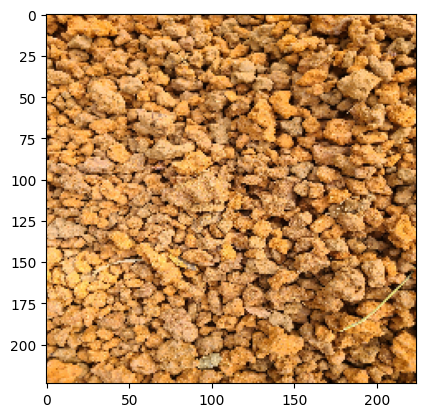

In [18]:
# Displaying one image
plt.imshow(cnn_train_data[0,:,:,:])

In [15]:
trr =np.array(train_target)
trr.shape

(300,)

In [16]:
tf.config.run_functions_eagerly(True)
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [25]:

# fiting the model
epochs = 2
history = model.fit(x=cnn_train_data,y=trr,
                       epochs = epochs,
                       validation_split = 0.15,
                       callbacks = [early_stopping, save_best])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8941 - f1_metric: 0.8808

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 8s 1s/step - loss: 0.2820 - accuracy: 0.8941 - f1_metric: 0.8808 - val_loss: 0.0204 - val_accuracy: 1.0000 - val_f1_metric: 1.0000
Epoch 2/2
8/8 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9373 - f1_metric: 0.9214

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 9s 1s/step - loss: 0.2242 - accuracy: 0.9373 - f1_metric: 0.9214 - val_loss: 0.0135 - val_accuracy: 1.0000 - val_f1_metric: 1.0000


In [26]:
pred = model.predict(cnn_test_data)

1/4 [======>.......................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 43ms/step


In [27]:
pred_conv = preprocess_cnn_pred(pred)

In [28]:
get_metrics(test_target, pred_conv)

(0.93,
 0.9166666666666666,
 0.9375,
 0.93,
 0.9066666666666666,
 0.93,
 0.93,
 0.9057239057239057,
 0.9292929292929293,
 0.93)

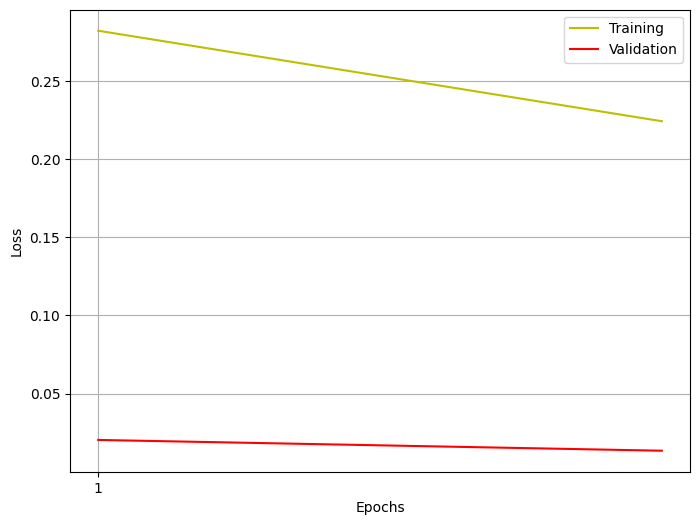

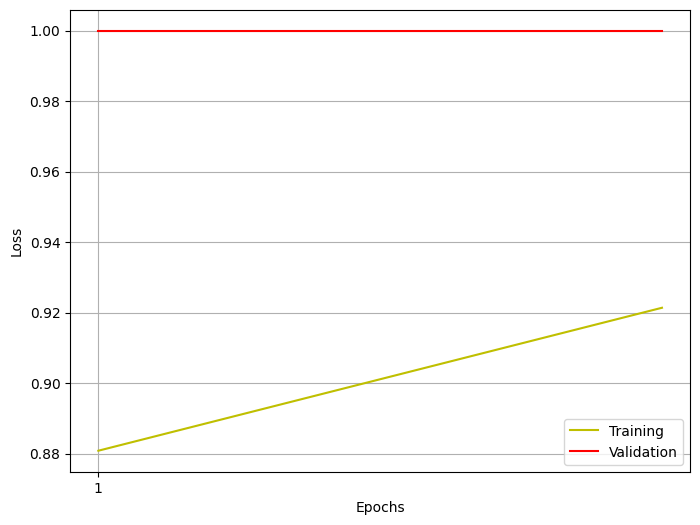

In [34]:
# Loss Plot
get_cnn_plot(history, metric='loss')

# f1_metric plot
get_cnn_plot(history, metric='f1_metric')